# Movie Recommender using Web Scraping


This tutorial will demonstrate the use of web scraping on a movie database website to find what other movies a user might be interseted in. One might assume that if they really liked a movie, they might also like one which has actors in common. Therefore, the general idea for this project is for the user to input their favorite movie, then we will find another movie who has the most actors in common. This will be done by web scraping the movie database site https://www.themoviedb.org/tv/60572 and gathering information about the cast of the user's preferred movie, which will be sent to a csv file locally.

This program will make use of the **scrapy** package, which will help use for web scraping. From there, we will begin making our web scraper. We begin by making a spider class, in this case **TmdbSpider** and hand it scrapy.Spider. This class will start with initial variables **name** and **start_url** and a **parse** function. **name** will be the name of our spider, **start_urls** is the url link to the webpage of the 1997 Pokemon TV series, which will be our starting place of choice. Finally, **parse** is what the program will call to do the web scraping and gather our data.

First, we will create a scrapy project by writing this in our terminal.

```python
conda activate PIC16B
scrapy startproject IMDB_scraper
cd IMDB_scraper
```

Then we write our class and its member functions:

In [1]:
#importing scrapy
import scrapy

# to run 
# scrapy crawl tmdb_spider -o movies.csv

#setting the name of the class and inputing the spider
class TmdbSpider(scrapy.Spider):
    
    #setting the name of the spider
    name = "tmdb_spider"
    
    #setting the starting url for our web scraping program to look from
    start_urls = ["https://www.themoviedb.org/tv/60572"]
    
    
    #
    def parse(self, response):
    """requests data from the cast page of a movie/tv series.

        Args:
            self(TmdbSpider) : this class
            response : data of the webpage to be pulled

    """
        #since all movies/tv series's cast page is the url + the word "cast" we add it to the url string to look up the cast
        page = response.url + "cast"
        
        #request "full credits" using the full credits function below on the cast page
        yield scrapy.Request(page, callback = self.parse_full_credits)



    def parse_full_credits(self, response):
    """gathers the list of the URLs of each of the movie/tv series' actors

    Args:
        self(TmdbSpider) : this class
        response : used as response.css("HTML path") to gather information from a HTML path

    """
        #here we use response.css() while handing it the HTML path to actors' page URL. a.attrib['href'] is used to gather the URL portion of the target
        #when finding the HTML path, I recommending hitting inspect element on the element you wish to scrape, and then coping the pathX. This is a huge hint as to what the HTML path should look like
        #note that this is only the link suffix, not a complete standalone link
        actorsPage = [a.attrib['href'] for a in response.css("div div section:nth-child(1) li a")]
        
        #we combine the suffix with the website domain to create working URLs towards an actor's page
        actorsURL = ["https://www.themoviedb.org" + actorpage for actorpage in actorsPage]
        
        #some enteries in the actorsURL list are not necessary, so we require that they must begin with https://www.themoviedb.org/person so that they are certainly an actor,
        #and also unique(by using the list(set(_list)) technique. Note this last step would typically be done in a separate line for readability, but it was a requirement for this to be done in 5 lines or less.
        actorsURL = list(set([a for a in actorsURL if a.startswith("https://www.themoviedb.org/person")]))
        
        #loop through the list of actor URLs, each time requesting the movies the actor played in by using the parse_actor_page function defined below
        for url in actorsURL:
            yield scrapy.Request(url, callback = self.parse_actor_page)



    def parse_actor_page(self, response):
    """gathers the names of the movies a particular actor has played in

    Args:
        self(TmdbSpider) : this class
        response : used as response.css("HTML path") to gather information from a HTML path

    """
        #name of the actor
        #this is done by getting the HTML path to the header, which also happens to be the actors name
        actor = response.css("div section:nth-child(1) div h2 a::text").get()
        
        #list of films the actor performed in
        #this is done by getting the HTML path to the list of casting roles
        #Note that this does not quite yet look like what we want(a lot of unwanted information). We will use .get() to later get rid of it
        films = response.css("div section:nth-child(4) div:nth-child(1) table:nth-child(1) tr td:nth-child(3) a bdi::text")
        
        #loops through the list of films
        for film in films:
            #in a csv file, create a row of the actors name and a film they played in
            yield{"actor": actor, "movieName": film.get()}

        #what will be written into the csv 

Now in the terminal we can activate our spider by running the command **scrapy crawl tmdb_spider -o results.csv** in the base directory of the scraper folder.
This will activate the parse command as well, and we should get the **results.csv** file in the base folder.


## Results


Now that we have a csv file with the actors and the roles they have had, we can count the movie/tv series which appears most frequently. To do so I will use a pandas dataframe and store the csv into it.

In [26]:
import pandas as pd
import plotly
import numpy as np

#open the csv file we made earlier
df = pd.read_csv('../../../TMDB_scraper/results.csv')
df.head()




,actor,movieName
0,Megumi Toyoguchi,The Apothecary Diaries
1,Megumi Toyoguchi,Tenchi Muyo! GXP Paradise Starting
2,Megumi Toyoguchi,Dead Mount Death Play
3,Megumi Toyoguchi,Insomniacs After School
4,Megumi Toyoguchi,Revenger


Next, make a dataframe with the movie names and their frequency using the **value_counts()** method

In [28]:
counts = df['movieName'].value_counts()

counts.head(15)

movieName
Pokémon                                               27
Pokémon: Mewtwo Returns                               24
Pokémon: The First Movie                              24
Pokémon: Arceus and the Jewel of Life                 24
Pokémon: Giratina and the Sky Warrior                 24
Pokémon: The Rise of Darkrai                          24
Pokémon the Movie: Mewtwo Strikes Back - Evolution    24
Pokémon: The Mastermind of Mirage Pokémon             24
Pokémon Heroes                                        24
Pokémon 4Ever                                         24
Pokémon 3: The Movie                                  24
Pikachu's Vacation                                    24
Pokémon: Zoroark - Master of Illusions                24
Pokémon the Movie: I Choose You!                      21
Pokémon: Lucario and the Mystery of Mew               21
Name: count, dtype: int64

### Visualization using plotly

<Axes: xlabel='movieName'>

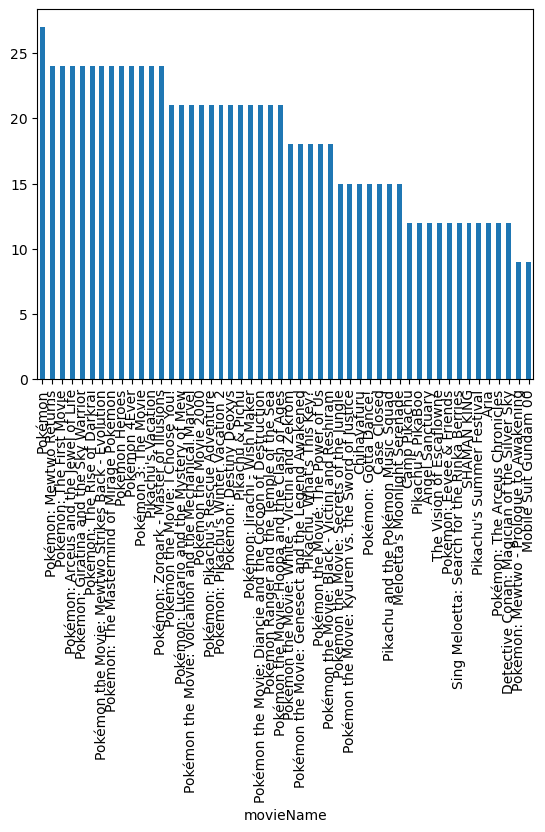

In [56]:
import matplotlib.pyplot as plt

#plot counts.head(20) as a bar graph
counts.head(50).plot(kind='bar')

This bargraph is rather hard to read. To see realisitic recommendations, lets look at only the top 15 choices

<Axes: xlabel='movieName'>

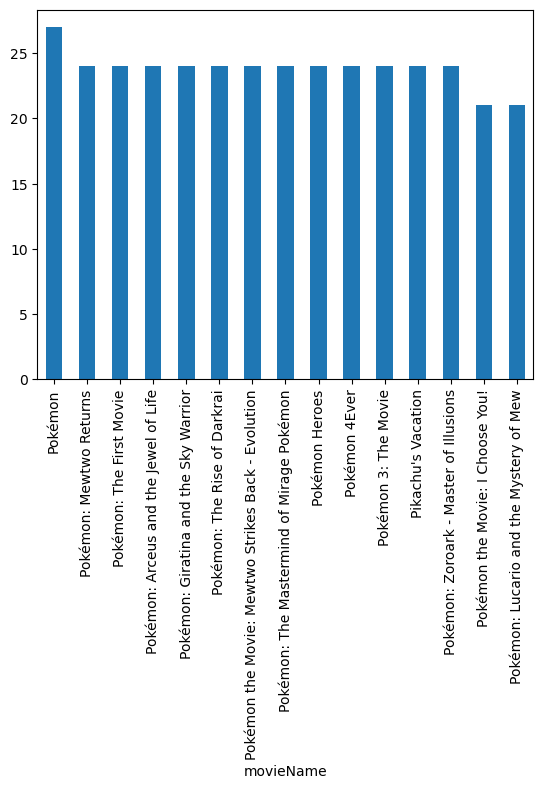

In [59]:
counts.head(15).plot(kind='bar')

## Conclusion

One can reasonably conclude that if your favorite show was the original 1997 Pokemon TV series, you are most likely to enjoy the Pokemon movies as well.